In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-20 01:34:55--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'housing.csv'

     0K .......... .......... .......... .......... ..........  3%  114K 12s
    50K .......... .......... .......... .......... ..........  7%  139K 10s
   100K .......... .......... .......... .......... .......... 10% 34.4K 19s
   150K .......... .......... .......... .......... .......... 14% 2.13M 14s
   200K .......... .......... .......... .......... .......... 17% 4.33M 10s
   250K .......... .......... .......... .......... .......... 21% 5.47M 8s
   300K .......... .......... .......... .......... .......... 25% 7.07M 7s
   350K .......... ........

In [7]:
columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv('housing.csv', usecols=columns)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
df["total_bedrooms"] = df.total_bedrooms.fillna(0)
df["median_house_value"] = np.log(df.median_house_value)

In [14]:
# TRAINING AND TEST:
from sklearn.model_selection import train_test_split
random_state = 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_state)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [19]:
# DICTVECTORIZER:

from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
#Question 1
#TRAINING REGRESSION MODEL:

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text


dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [23]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



In [26]:
#Question 2

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=random_state, n_jobs=-1)
rf.fit(X_train, y_train)

#MEAN SQUARED ERROR:
y_pred = rf.predict(X_val)
mean_squared_error(y_val, y_pred)

0.060200985425922754

In [28]:
#Question 3

from tqdm.auto import tqdm

scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=random_state)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    
    scores.append((n, mse))
    
scores

  0%|          | 0/20 [00:00<?, ?it/s]

[(10, 0.06020098542592274),
 (20, 0.057105779442822364),
 (30, 0.05538122876856864),
 (40, 0.054984527610740776),
 (50, 0.054295029741964713),
 (60, 0.05415424056325279),
 (70, 0.05391214339981424),
 (80, 0.05392976653864575),
 (90, 0.05379887462469828),
 (100, 0.053740128289375105),
 (110, 0.053654396828108825),
 (120, 0.05368450187884909),
 (130, 0.05371522828241398),
 (140, 0.05367116731556884),
 (150, 0.05363991685931704),
 (160, 0.0536339936027343),
 (170, 0.05360087252865755),
 (180, 0.05366911626833525),
 (190, 0.053678791381742884),
 (200, 0.05363733365234476)]

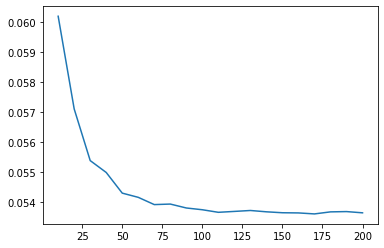

In [29]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'mse'])
plt.plot(df_scores.n_estimators, df_scores.mse)

In [30]:
#Question 4

scores = []

for d in tqdm([10, 15, 20, 25]):
    for n in tqdm(range(10, 201, 10)):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=random_state)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
    
        scores.append((d, n, mse))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

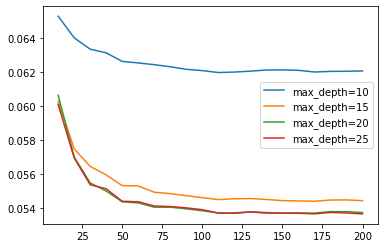

In [31]:
columns = ['max_depth', 'n_estimators', 'mse']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.mse,
             label='max_depth=%d' % d)

plt.legend()

In [32]:
#Question 5

rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=random_state, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [33]:
list(zip(rf.feature_importances_, dv.get_feature_names()))

[(0.016887718926334987, 'households'),
 (0.03292346114436802, 'housing_median_age'),
 (0.10063599497727256, 'latitude'),
 (0.09687277681176046, 'longitude'),
 (0.36388995120030926, 'median_income'),
 (0.0030667924625737133, 'ocean_proximity=<1H OCEAN'),
 (0.31090116055215333, 'ocean_proximity=INLAND'),
 (0.00035856627691673016, 'ocean_proximity=ISLAND'),
 (0.00027007686006509017, 'ocean_proximity=NEAR BAY'),
 (0.004219559248696653, 'ocean_proximity=NEAR OCEAN'),
 (0.030009924278211815, 'population'),
 (0.0190503564144457, 'total_bedrooms'),
 (0.020913660846891613, 'total_rooms')]

In [47]:
import re
import xgboost as xgb


ModuleNotFoundError: No module named 'xgboost'

In [38]:
#Question 6
# DMARTIX:

features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# evaluation 
watchlist = [(dtrain, 'train'), (dval, 'val')]

scores = {}

In [ ]:
%%capture output

xgb_params = {
  'eta': 0.3,         # ETA - learning rate
  'max_depth': 6,
  'min_child_weight': 1,

  'objective': 'reg:squarederror',
  'nthread': 8,

  'seed': 1,
  'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
# Function for producing a dataframe
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_mse', 'val_mse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

In [ ]:
scores['eta=0.3']